In [156]:
%load_ext autoreload
%autoreload 2
%connect_info
%pprint 1
# General imports
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from typing import NamedTuple, List,Tuple, Set
from dataclasses import dataclass
from gt.solutions.br import BrownRobinsonOptimizer
from IPython.display import display
np.set_printoptions(precision=3)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{
  "shell_port": 64998,
  "iopub_port": 64999,
  "stdin_port": 65001,
  "control_port": 65002,
  "hb_port": 65003,
  "ip": "127.0.0.1",
  "key": "e9dca718-c14941fba516d9c35418ad7c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b5ffd483-79ef-4fa0-81dc-44e875d75f57.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
Pretty printing has been turned OFF


In [342]:
#

original_matrix = np.array([
    [-5, -1, -1, -3, 0],
    [-4, 1, 0, -4, 0], 
    [-6, -1, 0, -5, 0], 
    [-3, 0, 0, -3, 0], 
    [2, -3, -4, 3, -3]
])

def normalize(m: np.ndarray) -> Tuple[np.ndarray, int]:
    norm_element = -np.min(m)
    if norm_element < 0:
        return m, 0
    return m + norm_element, norm_element


normalized_matrix, norm_element = normalize(original_matrix)
normalized_matrix

opt = BrownRobinsonOptimizer(original_matrix, max_steps=10000)
(A, B), states = opt.fit(0.01)
df = pd.DataFrame(states)
df = df.rename(columns={
    "step": "Шаг",
    "game_cost_current": "Величина ошибки",
    "A_income": "Выигрыши А",
    "B_loss": "Проигрыши Б",
    "A_frequencies": "Стратегия А",
    "B_frequencies": "Стратегия Б",
    "A_strategy": "Выбор А",
    "B_strategy": "Выбор Б",
    "min_win": "Минимальный выигрыш",
    "max_loss": "Максимальный проигрыш",
})
display(df.round(2))
game_cost = states[-1].min_win
print(f"GAME COST: {game_cost}")

,Шаг,Величина ошибки,Выигрыши А,Проигрыши Б,Стратегия А,Стратегия Б,Выбор А,Выбор Б,Минимальный выигрыш,Максимальный проигрыш
0,1,7,"[-5.0, -4.0, -6.0, -3.0, 2.0]","[-5.0, -1.0, -1.0, -3.0, 0.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",0,0,2,-5
1,2,9/2,"[-10.0, -8.0, -12.0, -6.0, 4.0]","[-3.0, -4.0, -5.0, 0.0, -3.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",4,0,2,-5/2
2,3,5/2,"[-11.0, -8.0, -12.0, -6.0, 0.0]","[-1.0, -7.0, -9.0, 3.0, -6.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",4,2,0,-5/2
3,4,3/2,"[-12.0, -8.0, -12.0, -6.0, -4.0]","[1.0, -10.0, -13.0, 6.0, -9.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",4,2,-1,-5/2
4,5,13/10,"[-13.0, -8.0, -12.0, -6.0, -8.0]","[3.0, -13.0, -17.0, 9.0, -12.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",4,2,-6/5,-5/2
5,6,13/10,"[-14.0, -8.0, -12.0, -6.0, -12.0]","[0.0, -13.0, -17.0, 6.0, -12.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",3,2,-6/5,-5/2
6,7,43/35,"[-15.0, -8.0, -12.0, -6.0, -16.0]","[-3.0, -13.0, -17.0, 3.0, -12.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",3,2,-6/5,-17/7
7,8,37/40,"[-16.0, -8.0, -12.0, -6.0, -20.0]","[-6.0, -13.0, -17.0, 0.0, -12.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",3,2,-6/5,-17/8
8,9,31/45,"[-17.0, -8.0, -12.0, -6.0, -24.0]","[-9.0, -13.0, -17.0, -3.0, -12.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",3,2,-6/5,-17/9
9,10,1/2,"[-18.0, -8.0, -12.0, -6.0, -28.0]","[-12.0, -13.0, -17.0, -6.0, -12.0]","[[1.0, 0.0, 0.0, 160.0, 81.0]]","[[92.0, 0.0, 150.0, 0.0, 0.0]]",3,2,-6/5,-17/10


GAME COST: -4/3


In [325]:
def to_df(matrix: np.ndarray) -> pd.DataFrame:
    return pd.DataFrame(data=matrix,
                        index=[f'a{i+1}' for i in range(matrix.shape[0])],
                        columns=[f'b{i+1}' for i in range(matrix.shape[1])])
df = to_df(normalized_matrix)
df

,b1,b2,b3,b4,b5
a1,1,5,5,3,6
a2,2,7,6,2,6
a3,0,5,6,1,6
a4,3,6,6,3,6
a5,8,3,2,9,3


In [326]:
def eliminate_nbrs(payout: pd.DataFrame) -> pd.DataFrame:
    # eliminate strictly dominated strategies and NBRs for zero-sum game of two players
    # do that for two players: player A and player B
    # For player A:
    #   Strategy k is (strictly) dominated by strategy w (i-th strategy IS ALWAYS better no matter what B chooses)
    #   if for each i in N: payout[i][k] (>)>= payout[i][k]
    # For player B:
    # 
    
    rows = payout.index
    filtered_rows = []
    for row in rows:
        logger.debug(f"Comparing row {row}")
        for compare_row in rows:
            if row != compare_row and (payout.loc[compare_row] >= payout.loc[row]).all():
                strictly = (payout.loc[compare_row] > payout.loc[row]).all()
                logger.info(f"Row {row} ({payout.loc[row].ravel()}) is {'strictly ' if strictly else ''}"
                            f"dominated by {compare_row} ({payout.loc[compare_row].ravel()})")
                break
        else:
            filtered_rows.append(row)
    
    columns = payout.columns
    filtered_columns = []
    for column in columns:
        logger.debug(f"Comparing column {column}")
        for compare_column in columns:
            if column != compare_column and (payout[compare_column] <= payout[column]).all():
                strictly = (payout[compare_column] < payout[column]).all()
                logger.info(f"Column {column} ({payout[column].ravel()}) {'strictly ' if strictly else ''}"
                            f"is dominated by {compare_column} ({payout[compare_column].ravel()})")
                break
        else:
            filtered_columns.append(column)
    
    removed_columns = [column for column in payout.columns if column not in filtered_columns]
    removed_rows = [row for row in payout.index if row not in filtered_rows]
    return payout[filtered_columns].loc[filtered_rows], removed_rows, removed_columns

def continiously_eliminate_nbrs(payout: pd.DataFrame) -> pd.DataFrame:
    previous = None
    current = payout
    iteration = 0
    eliminated_rows = []  # type: List[List[str]]
    eliminated_columns = []  # type: List[List[str]]
    while previous is None or not current.equals(previous):
        iteration += 1
        ending = int(str(iteration)[-1])
        logger.info(f"Running {iteration}{'st' if ending == 1 else 'nd' if ending == 2 else 'th'} "
                    f"iteration of NBR and dominated strategies elmination...")
        previous = current
        current, rows, columns  = eliminate_nbrs(payout=current)
        eliminated_rows.append(rows)
        eliminated_columns.append(columns)
    return current, eliminated_rows[:-1], eliminated_columns[:-1]
    
odf, rows, columns = continiously_eliminate_nbrs(df)
print(f"Удалённые строки: {rows}")
print(f"Удалённые столбцы: {columns}")
display(odf)
#(df.loc['a1'] >= df.loc['a2']).all()

def locate_nash(A_matrix: pd.DataFrame, B_matrix: pd.DataFrame) -> Set[Tuple[str, str]]:
    if A_matrix.shape != B_matrix.shape:
        raise ValueError(f"Matrices for both players have different shapes: {A_matrix.shape} and {B_matrix.shape}")
    if not A_matrix.columns.equals(B_matrix.columns):
        raise ValueError(f"Matrices for both players have different columns: {A_matrix.columns} and {B_matrix.columns}")
    if not A_matrix.index.equals(B_matrix.index):
        raise ValueError(f"Matrices for both players have different rows: {A_matrix.index} and {B_matrix.index}")
    
    logger.info(f"Maxima for player A (column): \n{A_matrix.max(axis=0)}")
    br = A_matrix.idxmax(axis=0)
    player_a_responses = {(i, br[i]) for i in br.index}
    logger.info(f"Best responses for A: {player_a_responses}")

    logger.info(f"Maxima for player B (row): \n{B_matrix.max(axis=1)}")
    br = B_matrix.idxmax(axis=1)
    player_b_responses = {(br[i], i) for i in br.index}
    logger.info(f"Best responses for B: {player_b_responses}")
    return player_b_responses.intersection(player_a_responses)



04:54:46 INFO:Running 1st iteration of NBR and dominated strategies elmination...
04:54:46 DEBUG:Comparing row a1
04:54:46 INFO:Row a1 ([1 5 5 3 6]) is dominated by a4 ([3 6 6 3 6])
04:54:46 DEBUG:Comparing row a2
04:54:46 DEBUG:Comparing row a3
04:54:46 INFO:Row a3 ([0 5 6 1 6]) is dominated by a2 ([2 7 6 2 6])
04:54:46 DEBUG:Comparing row a4
04:54:46 DEBUG:Comparing row a5
04:54:46 DEBUG:Comparing column b1
04:54:46 DEBUG:Comparing column b2
04:54:46 DEBUG:Comparing column b3
04:54:46 DEBUG:Comparing column b4
04:54:46 INFO:Column b4 ([3 2 1 3 9]) is dominated by b1 ([1 2 0 3 8])
04:54:46 DEBUG:Comparing column b5
04:54:46 INFO:Column b5 ([6 6 6 6 3]) is dominated by b3 ([5 6 6 6 2])
04:54:46 INFO:Running 2nd iteration of NBR and dominated strategies elmination...
04:54:46 DEBUG:Comparing row a2
04:54:46 DEBUG:Comparing row a4
04:54:46 DEBUG:Comparing row a5
04:54:46 DEBUG:Comparing column b1
04:54:46 DEBUG:Comparing column b2
04:54:46 INFO:Column b2 ([7 6 3]) is dominated by b3 ([6 

Удалённые строки: [['a1', 'a3'], [], ['a2']]
Удалённые столбцы: [['b4', 'b5'], ['b2'], []]


,b1,b3
a4,3,6
a5,8,2


In [311]:
# points:
def y(x, k, b):
    return x*k + b

def intersect(k1: float, b1: float, k2: float, b2: float) -> Tuple[float, float]:
    """
    """
    x = (b2 - b1) / (k1 - k2)
    return x, y(x, k1, b1)

def line_from_points(p2: Tuple[float, float], p1: Tuple[float, float]) -> Tuple[float, float]:
    """
    y1 = kx1 + b
    y2 = kx2 + b
    k = (y1-y2)/(x1 - x2)
    b = y1 - kx1
    """
    logger.debug(f"P1: {p1}, P2: {p2}")
    k = (p1[1] - p2[1]) / (p1[0] - p2[0])
    b = p1[1] - k*p1[0]
    return k, b
    
# a2: (0, 7) -> (1, 2)
# a5: (0, 3) -> (1, 9)
def graphical_mixed_solution(payout: pd.DataFrame, title: str=None) -> Tuple[float, float]:
    """
    Let's plot a graphical solution of the game.
    
    :param payout: (2,2)-matrix describing reward payout of selected pure strategies
    by two players with two strategies.
    
    We can draw a plot which will represent an allowed space of mixed strategies
    and rewards for player (A, for instance. B is the same) be that that mixed strategy selected.
    
    Let 0X axis represent the mix scale of two pure strategies for player A.
    Let 0Y axis represent the reward value of selected mix of two strategies for player A.
    
    Thus, let's imagine we have the following payout matrix:
    
       B1  B2
    A1 a11 a12
    A2 a21 a22
    
    Player A selects row i, and player B - column j. (row, column) -> a_i_j is the reward for A.
    
    Let's plot two points in our space:
    (mixed strategy for A consists of only A1 - pure A1 strategy)
    - (0, a[11]) for case when player B selected B1
    - (1, a[12]) for case when player B selected B2
    Connect them, and we get a line that can be interpreted as:
    - 0Y shows what reward will await player A if it has selected 
    pure A1 strategy but player B has
    a mixed strategy as a mix of B1 and B2 in ratio defined at 0X.
    
    Now, let's plot another set of two points in our space:
    (mixed strategy for A consists of only A2 - pure A2 strategy)
    - (0, a[21]) for case when player B selected B1
    - (1, a[22]) for case when player B selected B2
    It is interpreted the same way.
    
    Let's denote an intersection of two points as point OPT.
    
    OPT.x is the optimal strategy for A
    OPT.y is the game price.
    
    :NOTE: Repeat the same for price^T to get the optimal strategy for B.
    """
    fig, ax = plt.subplots(figsize=(10,10))
    plt.grid(which='both')
    if title is not None:
        fig.suptitle(title, fontsize=14)
    line_first = line_from_points(*enumerate(payout.iloc[0]))
    logger.debug(f"First line (k, b): {line_first}")
    line_second = line_from_points(*enumerate(payout.iloc[1]))
    logger.debug(f"Second line (k, b): {line_second}")
    
    x_space = np.linspace(0, 1, 20)
    ax.plot(x_space, [y(x, *line_first) for x in x_space])
    ax.plot(x_space, [y(x, *line_second) for x in x_space])
    optimal = intersect(*line_first, *line_second)
    ax.scatter(*optimal, s=30, color='green')
    fig.show()
    return np.array([1-optimal[0], optimal[0], optimal[1]])

04:39:34 DEBUG:P1: (1, 6), P2: (0, 3)
04:39:34 DEBUG:First line (k, b): (3.0, 3.0)
04:39:34 DEBUG:P1: (1, 2), P2: (0, 8)
04:39:34 DEBUG:Second line (k, b): (-6.0, 8.0)
e:\source\personal\university\2019\gametheory\.venv\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
04:39:34 DEBUG:P1: (1, 8), P2: (0, 3)
04:39:34 DEBUG:First line (k, b): (5.0, 3.0)
04:39:34 DEBUG:P1: (1, 2), P2: (0, 6)
04:39:34 DEBUG:Second line (k, b): (-4.0, 6.0)


Графическое решение для игрока A (p1 p2 цена игры): [0.444 0.556 4.667]
Графическое решение для игрока B (p1 p2 цена игры): [0.667 0.333 4.667]


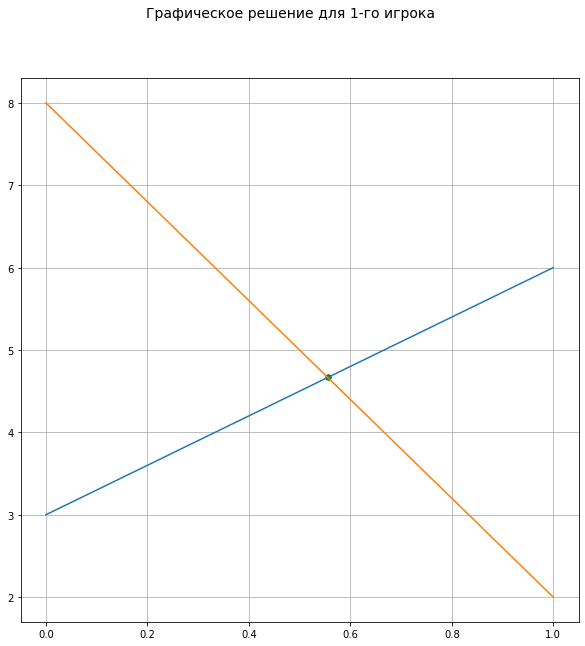

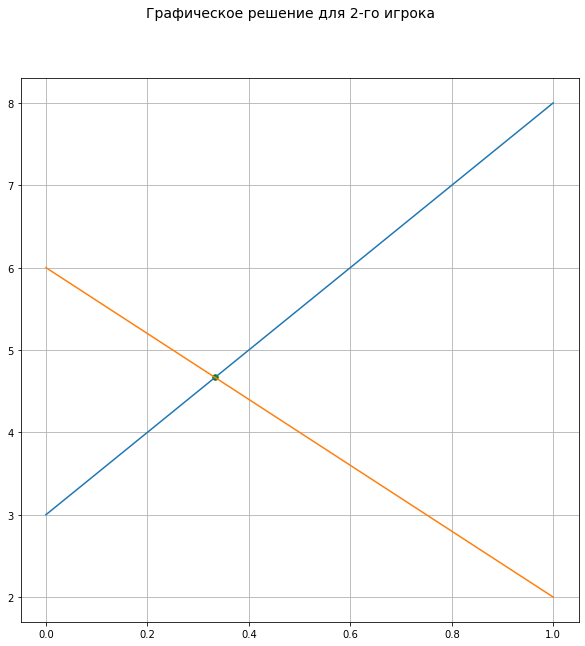

In [312]:
# Graphical solution
solution = graphical_mixed_solution(odf, title="Графическое решение для 1-го игрока")
print(f"Графическое решение для игрока A (p1 p2 цена игры): {solution}")
solution = graphical_mixed_solution(odf.T, title="Графическое решение для 2-го игрока")
print(f"Графическое решение для игрока B (p1 p2 цена игры): {solution}")

In [161]:
def analytical_solution(payout: pd.DataFrame) -> Tuple[float, float]:
    """
    Find the optimal mixed strategy:
    
    p1 + p2 = 1
    If other player uses 1st strategy:
    a11*p1 + a12*p1 = game price
    a21*p1 + a22*p2 = game price
    
    a11*p1 + a12*(1-p1) = a21*p1 + a22 * (1-p1)
    (a11-a12)*p1 + a12 = (a21 - a22)*p1 + a22
    p1 = (a22 - a12)/(a11 - a12 - a21 + a22)
    
    ...
    p1 = (a22 - a21) / (a22 + a11 - a21 - a12)
    game price =  a11 * p1 + a12 * (1 - p1)
    
    :return p1 and game price
    """
    a22 = payout.iloc[1][1]
    a21 = payout.iloc[1][0]
    a11 = payout.iloc[0][0]
    a12 = payout.iloc[0][1]
    p1 = (a22 - a12) / (a22 + a11 - a21 - a12)
    gp = a11 * p1 + a12 * (1 - p1)
    return np.array([p1, 1-p1, gp])


solution = analytical_solution(odf)
print(f"Решение для 1-го игрока (p1, p2, цена игры): {solution}")
solution = analytical_solution(odf.T)
print(f"Решение для 2-го игрока (p1, p2, цена игры): {solution}")

Решение для 1-го игрока (p1, p2, цена игры): [0.444 0.556 4.667]
Решение для 2-го игрока (p1, p2, цена игры): [0.667 0.333 4.667]


In [171]:
from scipy.optimize import linprog


def linprog_simplex(payout: pd.DataFrame):
    a22 = payout.iloc[1][1]
    a21 = payout.iloc[1][0]
    a11 = payout.iloc[0][0]
    a12 = payout.iloc[0][1]
    # Maximize
    player1_opt = linprog(c=np.array([1, 1]), method='simplex', 
            b_ub=[-1, -1], bounds=(0, None),
            A_ub=np.array([[-a11, -a12], [-a21, -a22]]))
    game_price = 1/player1_opt.fun
    print(f"Симплекс метод для первого игрока:\n"
          f"F = x1 + x2 -> max (1/GamePrice = x1 + x2 -> min)\n"
          f"{a11}*x1 + {a12}*x2 >= 1\n"
          f"{a21}*x1 + {a22}*x2 >= 1")
    print(f"Симплекс-метод для первого игрока: цена игры={game_price:.2f}, стратегии={player1_opt.x*game_price}")
    # Minimize
    player2_opt = linprog(c=np.array([-1, -1]), method='simplex', 
            b_ub=[1, 1], bounds=(0, None),
            A_ub=np.array([[a11, a21], [a12, a22]]))
    game_price = -1/player2_opt.fun
    print(f"Симплекс метод для второго игрока:\n"
          f"F = x1 + x2 -> min\n"
          f"{a11}*x1 + {a21}*x2 <= 1\n"
          f"{a12}*x1 + {a22}*x2 <= 1")
    print(f"Симплекс-метод для второго игрока: цена игры={game_price:.3f}, стратегии={player2_opt.x*game_price}")

linprog_simplex(odf)

Симплекс метод для первого игрока:
F = x1 + x2 -> max (1/GamePrice = x1 + x2 -> min)
3*x1 + 6*x2 >= 1
8*x1 + 2*x2 >= 1
Симплекс-метод для первого игрока: цена игры=4.67, стратегии=[0.444 0.556]
Симплекс метод для второго игрока:
F = x1 + x2 -> min
3*x1 + 8*x2 <= 1
6*x1 + 2*x2 <= 1
Симплекс-метод для второго игрока: цена игры=4.667, стратегии=[0.667 0.333]


e:\source\personal\university\2019\gametheory\.venv\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Точка пересечения ограничений: [0.095 0.119] (F=0.214, стоимость игры=4.666)


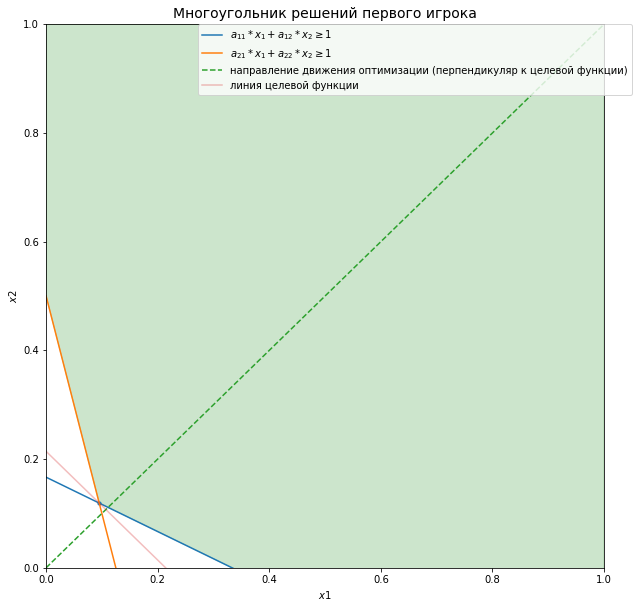

Точка пересечения ограничений: [0.143 0.071] (F=0.214, стоимость игры=4.667)


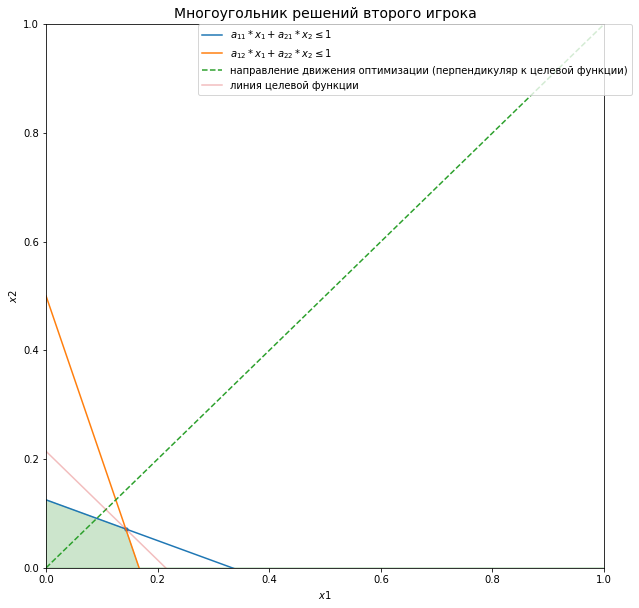

In [331]:
# Graphical method

def plot(x1, labels, constraints, bounding, accuracy, title):
    plt.figure(figsize=(10,10))
    for i, constraint in enumerate(constraints):
        plt.plot(x1, constraint, label=labels[i])
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xlabel(r'$x1$')
    plt.ylabel(r'$x2$')
    
    plt.fill_between(x1, *bounding, 1, color='green', alpha=0.2)
    intersection_point = np.where(np.all(np.isclose(constraints, constraints[0], atol=accuracy), axis=0))
    point = np.dstack((x1[intersection_point], constraints[0][intersection_point]))[0].ravel()
    plt.plot(x1, x1, linestyle='--',label='направление движения оптимизации (перпендикуляр к целевой функции)')
    plt.plot(x1, y(x1, -1, point[1]+point[0]), alpha=0.3, label='линия целевой функции')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
    print(f"Точка пересечения ограничений: {point} (F={sum(point):.3f}, стоимость игры={1/sum(point):.3f})")
    plt.scatter(*point, s=10)
    plt.title(title, fontsize=14)
    plt.show()

def linprog_graphical(payout: pd.DataFrame, accuracy: float=0.0001):
    x1 = np.linspace(0, 1, 2/(accuracy))
    a22 = payout.iloc[1][1]
    a21 = payout.iloc[1][0]
    a11 = payout.iloc[0][0]
    a12 = payout.iloc[0][1]
    
    player1_constraints = [
        # a11 * x1 + a12 * x2 >= 1 => x2 >= (1 - a11*x1)/a12
        (1 - a11 * x1)/a12,
        # a21 * x1 + a22 * x2 >= 1 => x2 >= (1 - a21*x1)/a22
        (1 - a21 * x1)/a22,
    ]
    player2_constraints = [
        # a11 * x1 + a21 * x2 <= 1 => x2 <= (1 - a11*x1)/a21
        (1 - a11 * x1)/a21,
        # a12 * x1 + a22 * x2 <= 1 => x2 <= (1 - a12*x1)/a22
        (1 - a12 * x1)/a22,
    ]
    plot(x1,
         labels=[r'$a_{11} * x_1 + a_{12} * x_2\geq1$', 
                 r'$a_{21} * x_1 + a_{22} * x_2\geq1$'],
         bounding=(np.maximum(*player1_constraints), 1), 
         constraints=player1_constraints,
         accuracy=accuracy,
         title="Многоугольник решений первого игрока")
    plot(x1, 
         labels=[r'$a_{11} * x_1 + a_{21} * x_2\leq1$', 
                 r'$a_{12} * x_1 + a_{22} * x_2\leq1$'],
         bounding=(0, np.minimum(*player2_constraints)),
         constraints=player2_constraints,
         accuracy=accuracy,
         title="Многоугольник решений второго игрока")
    
    

linprog_graphical(odf)